### III- Comparaison entre les modèles de Random Forest et XgBoost

In [1]:
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import sys
import os

print("Current working directory:", os.getcwd())

sys.path.append(os.path.abspath('..'))
print("Updated sys.path:", sys.path)
from fonctions import defined_X_y
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from skopt.space import Real,Integer,Categorical
from skopt import BayesSearchCV
from timeit import default_timer as timer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

Current working directory: c:\Users\lulil\OneDrive\Documents\SCORING-TIDE\modélisation
Updated sys.path: ['c:\\Users\\lulil\\OneDrive\\Documents\\SCORING-TIDE\\modélisation', 'c:\\Users\\lulil\\anaconda3\\python39.zip', 'c:\\Users\\lulil\\anaconda3\\DLLs', 'c:\\Users\\lulil\\anaconda3\\lib', 'c:\\Users\\lulil\\anaconda3', '', 'C:\\Users\\lulil\\AppData\\Roaming\\Python\\Python39\\site-packages', 'c:\\Users\\lulil\\anaconda3\\lib\\site-packages', 'c:\\Users\\lulil\\anaconda3\\lib\\site-packages\\win32', 'c:\\Users\\lulil\\anaconda3\\lib\\site-packages\\win32\\lib', 'c:\\Users\\lulil\\anaconda3\\lib\\site-packages\\Pythonwin', 'c:\\Users\\lulil\\OneDrive\\Documents\\SCORING-TIDE']


In [2]:
table = pq.read_table('../data/train_dummies_data.parquet')
t = pq.read_table('../data/test_dummies_data.parquet')
train_df = table.to_pandas()
test_df = t.to_pandas()

In [3]:
#la base de données étant trop large Xgboost n'est pas performant
train_df = train_df.sample(frac=0.8, random_state=42)
test_df = test_df.sample(frac=0.8, random_state=42)

In [4]:
X_train, y_train = defined_X_y(train_df, 'fraude')
X_test, y_test = defined_X_y(test_df, 'fraude')

1. Random Forest

In [14]:
param_dict_bayes_RF = {
    'n_estimators' : Integer(10,200),
    'criterion': Categorical(['gini', 'entropy']), 
    'max_depth': Integer(2,10),
    'bootstrap':Categorical([True,False])}

In [15]:
#recherche des hyperparèmetres optimaux

opt = BayesSearchCV(RandomForestClassifier(),param_dict_bayes_RF,n_iter=5,cv=3,scoring = 'roc_auc',random_state=1)


opt.fit(X_train, y_train)
best_param_opti_bayes =opt.best_params_
best_score_opti_bayes = opt.best_score_
all_result_opti_bayes = opt.cv_results_
print(" #### RECHERCHE DES PARAMETRES OPTIMAUX POUR LE RANDOM FOREST #### ")
print("\n Paramètres optimaux : ")
best_param_opti_bayes =opt.best_params_
print(best_param_opti_bayes)
best_score_opti_bayes = opt.best_score_
print("\n Résultats  : " + str(best_score_opti_bayes))

 #### RECHERCHE DES PARAMETRES OPTIMAUX POUR LE RANDOM FOREST #### 

 Paramètres optimaux : 
OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 8), ('n_estimators', 63)])

 Résultats  : 0.8156822015135218


In [16]:
rf_clf = RandomForestClassifier(**opt.best_params_)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=8, n_estimators=63)

In [17]:
importance_variable_rf = pd.DataFrame()
importance_variable_rf["Variable"] = X_train.columns
importance_variable_rf["Feature Importance"] = rf_clf.feature_importances_

# Sort the DataFrame by feature importance
importance_variable_rf = importance_variable_rf.sort_values(by="Feature Importance", ascending=False)

# Display the DataFrame
print(importance_variable_rf)

                     Variable  Feature Importance
3                   fm_sum_24            0.167085
2    fm_velocity_condition_24            0.142007
4        fm_redondance_mcc_24            0.080956
485                  mcc_3748            0.059217
24                   pays_076            0.055285
..                        ...                 ...
381                  mcc_3563            0.000000
382                  mcc_3565            0.000000
383                  mcc_3567            0.000000
384                  mcc_3568            0.000000
462                  mcc_3716            0.000000

[876 rows x 2 columns]


XgBoost

In [5]:
param_dict_XGB = {
    'objective':Categorical(['binary:logistic']),
    'booster':Categorical(['gbtree']), #,'gblinear','dart'
    'base_estimator' : Categorical([LogisticRegression(),DecisionTreeClassifier()]),
    'learning_rate' : Real(0.05,1, prior='uniform'),
    'label' : X_train.columns.tolist()}

In [6]:
# Instanciation de l'optimisation bayésienne
opt = BayesSearchCV(xgb.XGBClassifier(),param_dict_XGB,n_iter=5,cv=5,scoring = 'roc_auc',random_state=1)

In [7]:
#permet d'optimiser la structure du Df
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [8]:
opt.fit(X_train, y_train)
best_param_opti_bayes =opt.best_params_
best_score_opti_bayes = opt.best_score_
all_result_opti_bayes = opt.cv_results_
print(" #### RECHERCHE DES PARAMETRES OPTIMAUX POUR XGBOOST #### ")
print("\n Paramètres optimaux : ")
best_param_opti_bayes =opt.best_params_
print(best_param_opti_bayes)
best_score_opti_bayes = opt.best_score_
print("\n Résultats  : " + str(best_score_opti_bayes))

c:\Users\lulil\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:21:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "base_estimator", "label" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lulil\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:23:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "base_estimator", "label" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lulil\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "base_estimator", "label" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lulil\anaconda3\

 #### RECHERCHE DES PARAMETRES OPTIMAUX POUR XGBOOST #### 

 Paramètres optimaux : 
OrderedDict([('base_estimator', DecisionTreeClassifier()), ('booster', 'gbtree'), ('label', 'pays_498'), ('learning_rate', 0.43186891435283886), ('objective', 'binary:logistic')])

 Résultats  : 0.8678170565457719


In [9]:
xgb_clf = xgb.XGBClassifier(**opt.best_params_)
xgb_clf.fit(X_train,y_train)

c:\Users\lulil\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:52:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "base_estimator", "label" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_estimator=DecisionTreeClassifier(), base_score=None,
              booster='gbtree', callbacks=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, label='pays_498',
              learning_rate=0.43186891435283886, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [10]:
importance_variable_xgb = pd.DataFrame()
importance_variable_xgb["Variable"]= X_train.columns # X_train.columns pour utiliser les anciens noms
importance_variable_xgb["Feature Importance"] = xgb_clf.feature_importances_ 

In [11]:
importance_variable_xgb.sort_values(by = "Feature Importance", axis=0, ascending=False, inplace=True)
importance_variable_xgb.head(5)

,Variable,Feature Importance
24,pays_076,0.020389
154,pays_792,0.020259
12,pays_036,0.015282
648,mcc_5921,0.015217
534,mcc_4814,0.013739


# 1. Approche statistique : maximiser un critère tel que l'AUC

`Courbes ROC sur données train`

In [18]:
#pour le train

#RF
fpr_test_RF, tpr_test_RF, _ = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
roc_auc_test_RF = auc(fpr_test_RF, tpr_test_RF)

In [19]:
#XGBoost
fpr_train_XGB, tpr_train_XGB, thresholds_train_XGB = roc_curve(y_train, xgb_clf.predict_proba(X_train)[:,1])
roc_auc_train_XGB = auc(fpr_train_XGB, tpr_train_XGB)

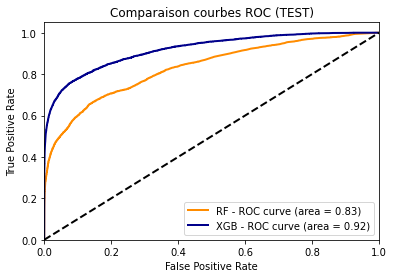

In [20]:
# ROC

lw = 2
# Random Forest
plt.plot(fpr_test_RF, tpr_test_RF, color='darkorange',
         lw=lw, label='RF - ROC curve (area = %0.2f)' % roc_auc_test_RF)


# XGBoost
plt.plot(fpr_train_XGB, tpr_train_XGB, color='darkblue',
         lw=lw, label='XGB - ROC curve (area = %0.2f)' % roc_auc_train_XGB)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courbes ROC (TEST)')
plt.legend(loc="lower right")
plt.show()

`Courbes ROC sur données test`

In [21]:
#pour le test

#RF
fpr_test_RF, tpr_test_RF, _ = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
roc_auc_test_RF = auc(fpr_test_RF, tpr_test_RF)

#XGBOOST
fpr_test_XGB, tpr_test_XGB, _ = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:,1])
roc_auc_test_XGB = auc(fpr_test_XGB, tpr_test_XGB)

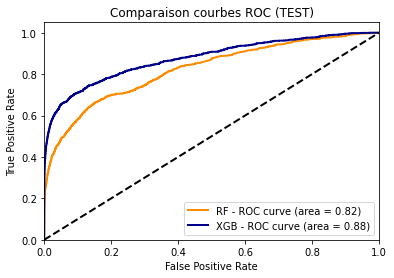

In [22]:
# Random Forest
plt.plot(fpr_test_RF, tpr_test_RF, color='darkorange',
         lw=lw, label='RF - ROC curve (area = %0.2f)' % roc_auc_test_RF)

# XGBoost
plt.plot(fpr_test_XGB, tpr_test_XGB, color='darkblue',
         lw=lw, label='XGB - ROC curve (area = %0.2f)' % roc_auc_test_XGB)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courbes ROC (TEST)')
plt.legend(loc="lower right")
plt.show()

In [23]:
print("APP - RF : LogLoss  : " + str(log_loss(y_train, rf_clf.predict_proba(X_train)[:,1])))
print("APP - XGB : LogLoss  : " + str(log_loss(y_train, xgb_clf.predict_proba(X_train)[:,1])),'\n')
print("TEST - RF : LogLoss  : " + str(log_loss(y_test, rf_clf.predict_proba(X_test)[:,1])))
print("TEST - XGB : LogLoss  : " + str(log_loss(y_test, xgb_clf.predict_proba(X_test)[:,1])))

APP - RF : LogLoss  : 0.03280455402961203
APP - XGB : LogLoss  : 0.021715305929057804 

TEST - RF : LogLoss  : 0.03156510356213931
TEST - XGB : LogLoss  : 0.0233002024443649


# 2. Approche métier : arbitrer utiliser le recall

In [24]:
precision_test_RF,recall_test_RF,thresholds_test_RF = precision_recall_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
precision_test_XGB,recall_test_XGB,thresholds_test_XGB = precision_recall_curve(y_test, xgb_clf.predict_proba(X_test)[:,1])

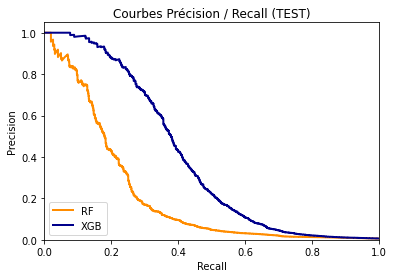

In [25]:
lw = 2
plt.plot(recall_test_RF,precision_test_RF, color='darkorange',
         lw=lw, label='RF')

plt.plot(recall_test_XGB,precision_test_XGB, color='darkblue',
         lw=lw, label='XGB')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbes Précision / Recall (TEST)')
plt.legend(loc="lower left")
plt.show()

In [26]:
## Choix du seuil - Tableau seuil /
table_choix_seuil = pd.DataFrame()
table_choix_seuil["Seuil"] = [0] + list(thresholds_test_RF)
table_choix_seuil["Precision_test_RF"] = precision_test_RF
table_choix_seuil["Recall_test_RF"] = recall_test_RF
table_choix_seuil.sort_values(by = "Seuil", axis=0, ascending=False, inplace=True)
table_choix_seuil.head(10)

,Seuil,Precision_test_RF,Recall_test_RF
55356,0.254087,1.0,0.000000
55355,0.232070,1.0,0.000912
55354,0.149032,1.0,0.001825
55353,0.146586,1.0,0.002737
55352,0.144933,1.0,0.003650
55351,0.137028,1.0,0.004562
55350,0.133782,1.0,0.005474
55349,0.128900,1.0,0.006387
55348,0.128703,1.0,0.007299
55347,0.127223,1.0,0.008212
